In [2]:
import os                              
import numpy as np
from numpy import number                    
import pandas as pd                     
import matplotlib.pyplot as plt  
import math
from typing import List
from azure.quantum.optimization import Problem, ProblemType, Term
from azure.quantum.optimization import ParallelTempering
from azure.quantum.optimization import Term, SlcTerm
%pip install PyPortfolioOpt
%pip install cvxopt
%pip install cvxpy
%pip install plotly==5.9.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Data Preprocessing

In [3]:
stocks = [stock.split('.')[0] for stock in sorted(os.listdir("Datasets/BSE 10 stocks"))]
stocks = stocks[1:]

print(stocks)

['HDFCBANK', 'HINDUNILVR', 'INFY', 'M&M', 'MARUTI', 'NESTLEIND', 'NTPC', 'ONGC', 'RELIANCE', 'TCS']


In [4]:
dates = pd.date_range('2021-06-27', '2022-06-27') 
data = pd.DataFrame({'Time': dates})


In [5]:
for stock in stocks:
    prices = pd.read_csv("Datasets/BSE 10 stocks/"+stock+".csv", usecols=['Date', 'WAP'])
    #print(prices)
    prices['Date'] = pd.to_datetime(prices['Date'], dayfirst = True)  
    #print(prices)
    prices.rename(                                                            
        columns={"Date": "Time", "WAP": stock},
        inplace=True
    )
    data = pd.merge(data,prices)

In [6]:
portfolio = pd.DataFrame(data['Time'])

In [7]:
cp = data .drop(['Time'], axis=1).tail(1).to_numpy()
cp = cp[0]
cp

array([ 1362.98508175,  2325.06299449,  1476.05466426,  1082.33540129,
        8485.91328009, 17331.08250737,   138.12682584,   140.30607119,
        2513.46585183,  3332.54017435])

In [8]:
r = data[(data['Time'] >= '2021-06-27')] \
    .drop(['Time'], axis=1) \
    .pct_change(fill_method='ffill')
r.head()

,HDFCBANK,HINDUNILVR,INFY,M&M,MARUTI,NESTLEIND,NTPC,ONGC,RELIANCE,TCS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.007444,0.004518,-0.003719,-0.012107,-0.013844,0.004683,-0.007994,-0.022936,-0.002515,-0.000406
2,0.001268,0.006934,0.012004,-0.000119,0.009329,0.002995,0.007432,-0.006999,0.005660,0.005163
3,-0.008289,-0.004113,-0.011562,0.005765,-0.001113,-0.001757,-0.002304,-0.011125,0.001306,-0.005388
4,-0.005006,-0.000344,-0.006978,-0.008266,0.000992,-0.004671,0.009426,0.011152,0.004894,-0.010042


In [72]:
mu = r.mean().to_numpy()
sigma = r.cov().to_numpy()
n=len(stocks)
print(mu)
print(sigma)


[-3.00405913e-04 -1.30064817e-04 -1.38454654e-04  1.39666650e-03
  5.85765343e-04  4.07695216e-06  7.87364886e-04  7.54522881e-04
  8.23689561e-04  6.35391242e-05]
[[ 2.30869850e-04  8.09591286e-05  8.89928629e-05  1.01682190e-04
   1.04374309e-04  5.31190925e-05  3.90028603e-05  1.27687077e-06
   7.65492664e-05  7.33936152e-05]
 [ 8.09591286e-05  1.73364445e-04  4.50707233e-05  7.87397216e-05
   8.92841709e-05  7.39565780e-05  3.43997410e-05 -1.67462894e-05
   6.10502944e-05  5.72677814e-05]
 [ 8.89928629e-05  4.50707233e-05  2.22677880e-04  6.91954269e-05
   3.82436535e-05  3.88530838e-05  2.26276373e-05  3.06702062e-05
   8.25130977e-05  1.26741988e-04]
 [ 1.01682190e-04  7.87397216e-05  6.91954269e-05  2.90708316e-04
   1.49349297e-04  5.13302723e-05  7.73516281e-05  1.58682856e-05
   1.19581211e-04  6.53565629e-05]
 [ 1.04374309e-04  8.92841709e-05  3.82436535e-05  1.49349297e-04
   2.92936129e-04  4.87532414e-05  6.19591547e-05 -2.20330044e-05
   5.97921962e-05  4.60855199e-05]
 

In [10]:
import pypfopt
pypfopt.__version__

'1.5.3'

,HDFCBANK,HINDUNILVR,INFY,M&M,MARUTI,NESTLEIND,NTPC,ONGC,RELIANCE,TCS
HDFCBANK,0.058179,0.020402,0.022426,0.025624,0.026302,0.013386,0.009829,0.000322,0.019290,0.018495
HINDUNILVR,0.020402,0.043688,0.011358,0.019842,0.022500,0.018637,0.008669,-0.004220,0.015385,0.014431
INFY,0.022426,0.011358,0.056115,0.017437,0.009637,0.009791,0.005702,0.007729,0.020793,0.031939
M&M,0.025624,0.019842,0.017437,0.073258,0.037636,0.012935,0.019493,0.003999,0.030134,0.016470
MARUTI,0.026302,0.022500,0.009637,0.037636,0.073820,0.012286,0.015614,-0.005552,0.015068,0.011614
NESTLEIND,0.013386,0.018637,0.009791,0.012935,0.012286,0.026882,0.004540,-0.003368,0.011144,0.010245
NTPC,0.009829,0.008669,0.005702,0.019493,0.015614,0.004540,0.058915,0.036255,0.013297,0.008646
ONGC,0.000322,-0.004220,0.007729,0.003999,-0.005552,-0.003368,0.036255,0.116620,0.010377,0.008928
RELIANCE,0.019290,0.015385,0.020793,0.030134,0.015068,0.011144,0.013297,0.010377,0.050700,0.017158
TCS,0.018495,0.014431,0.031939,0.016470,0.011614,0.010245,0.008646,0.008928,0.017158,0.040081


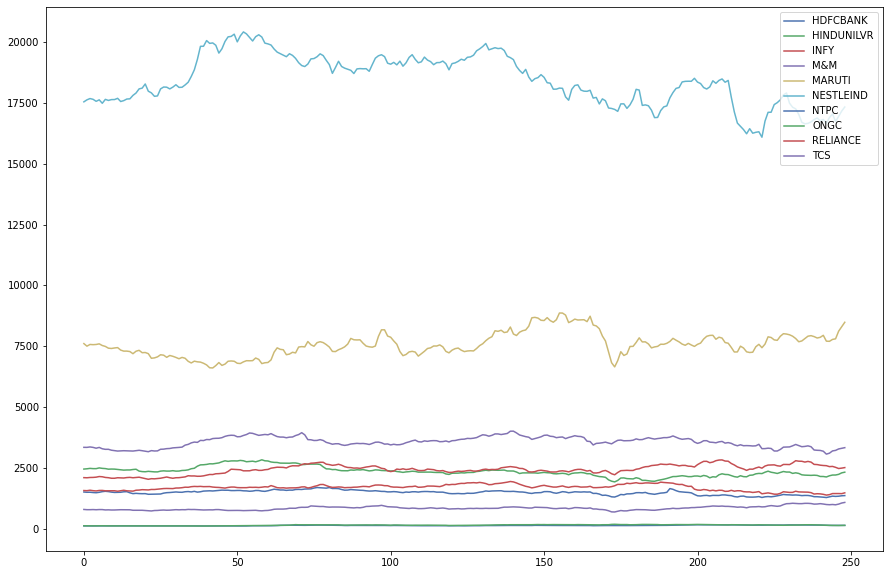

In [11]:
from pypfopt import risk_models
from pypfopt import plotting

all_prices=  data.drop(['Time'], axis=1)
all_prices.plot(figsize=(15,10));
sample_cov = risk_models.sample_cov(all_prices, frequency=252)
sample_cov

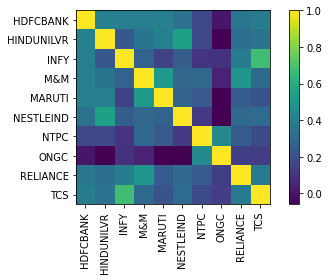

In [12]:
plotting.plot_covariance(sample_cov, plot_correlation=True);

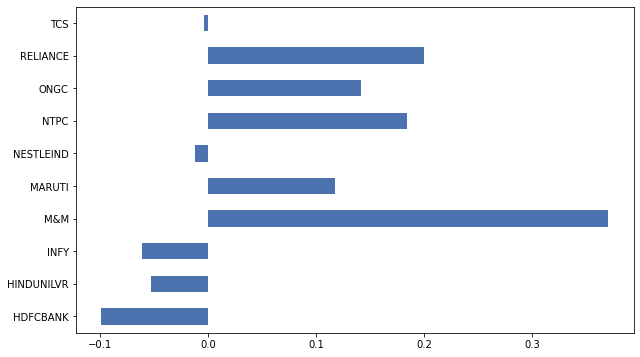

In [13]:
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

muc = expected_returns.mean_historical_return(all_prices)
muc.plot.barh(figsize=(10,6));


In [14]:
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(muc,sample_cov)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")  # saves to file
w_classical = [0.0161,0.24485, 0.10312 , 0.23497, 0.01057, 0.20492, 0.13906, 0.04642]
w_classical_all = [0,0.0161,0,0.24485,0.10312,0,0.23497,0,0,0,0,0.01057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.20492,0,0,0,0.13906,0,0,0,0,0,0,0,0,0,0,0.04642,0,0,0,0,0,0,0]
print(cleaned_weights)
ef.portfolio_performance(verbose=True)


OrderedDict([('HDFCBANK', 0.0), ('HINDUNILVR', 0.0), ('INFY', 0.0), ('M&M', 0.66596), ('MARUTI', 0.0), ('NESTLEIND', 0.0), ('NTPC', 0.13957), ('ONGC', 0.08761), ('RELIANCE', 0.10686), ('TCS', 0.0)])
Expected annual return: 30.6%
Annual volatility: 21.2%
Sharpe Ratio: 1.35


(0.30641738745618524, 0.21205898214153968, 1.3506496379625867)

In [15]:
from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "e87e6b08-4913-4522-9206-ba18a56ee0fa",
    resource_group = "AzureQuantum",
    name = "MTCProjectQuantumSharique",
    location = "East US"
)

"""
from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "6e02aef9-2670-4418-92b8-7659cf5605d2",
    resource_group = "azurequantum",
    name = "workspace1",
    location = "japaneast"
)
"""

'\nfrom azure.quantum import Workspace\nworkspace = Workspace (\n    subscription_id = "6e02aef9-2670-4418-92b8-7659cf5605d2",\n    resource_group = "azurequantum",\n    name = "workspace1",\n    location = "japaneast"\n)\n'

Objective Function

In [16]:
tmu = mu

def Return_w(mu,n):
    """Calculates the Terms for the return component of the cost function

    Parameters
    ----------
    mu : np.array
        Expected return of each stock 
    n : integer
        Number of stocks
        
    Returns
    -------
    terms: list
        List of Terms associated with the return component of the cost function
    """
    
    terms=[]
    
    for i in range(0,n):
        for j in range(0,8):
            tmu[i] = (mu[i] * 2**j) / 100
            terms.append(Term( c = -1*(mu[i] * 2**j) / 100 , indices=[i,j]))
    print("Number of terms in return: ", len(terms))
    print(tmu)
    return terms

In [17]:
 
def Return(mu,n):
    """Calculates the Terms for the return component of the cost function

    Parameters
    ----------
    mu : np.array
        Expected return of each stock 
    n : integer
        Number of stocks
        
    Returns
    -------
    terms: list
        List of Terms associated with the return component of the cost function
    """
    
    terms=[]
    
    for i in range(0,n):
        
        terms.append(Term(c=-1*mu[i] , indices=[i]))
    print("Number of terms in return: ", len(terms))
    return terms

In [18]:
tsigma = sigma
def risk_w(sigma,n,risk_aversion):

    """Calculates the Terms for the risk component of the cost function

    Parameters
    ----------
    sigma : np.array
        Covariance matrix of the dataset 
    n : integer
        Number of stocks
    risk_aversion: integer
        Risk aversion parameter
        
    Returns
    -------
    terms: list
        List of Terms associated with the risk component of the cost function
    """
    
    terms=[]
    
    for i in range(0,n):
        for j in range(0,n):
            for k in range(0,8):
                for l in range(0,8):
                    tsigma[i][j] = sigma[i][j] * ((risk_aversion/2) * 2**k * 2 **l) / (100*100)
                    terms.append(Term(c= (sigma[i][j] * (risk_aversion/2) * 2**k * 2 **l) / (100*100), indices=[i,j,k,l]))
    print("Number of terms in risk: ", len(terms))
    print(tsigma)
    return terms

In [19]:
def risk(sigma,n,risk_aversion):

    """Calculates the Terms for the risk component of the cost function

    Parameters
    ----------
    sigma : np.array
        Covariance matrix of the dataset 
    n : integer
        Number of stocks
    risk_aversion: integer
        Risk aversion parameter
        
    Returns
    -------
    terms: list
        List of Terms associated with the risk component of the cost function
    """
    
    terms=[]
    
    for i in range(0,n):
        for j in range(0,n):
            terms.append(Term(c= sigma[i][j] * (risk_aversion/2) , indices=[i,j]))
    print("Number of terms in risk: ", len(terms))
    return terms

Constraints

In [20]:
def budget_constraint(penalty_weight,n,b):

    '''
      Calculates the Terms for the normalized budget constraint

        Parameters
        ----------
        penalty_weight : integer
            Lagrange multiplier to penalise the stocks that don't obey the constraint 
        n : integer
            Number of stocks
        b : integer
            Normalized budget / stock appretite must be less than n

        Returns
        -------
        slc: list
            List of SlcTerms associated with the penalty constraint
        
    '''

    terms=[]
    for i in range(0,n):
        terms.append(Term(c= 1 , indices=[i]))
    terms.append(Term(c=-b, indices=[]))
    slc = []
    slc.append(SlcTerm(
            terms,
            c=1
        ))
    return slc

Results

In [21]:
terms=[]
t1 = Return(mu,n)
t2 = risk(sigma,n,1)
terms= t1+ t2 
problem = Problem(name="Portfolio optimization", problem_type=ProblemType.pubo, terms=terms)

Number of terms in return:  10
Number of terms in risk:  100


In [22]:
solver = ParallelTempering(workspace)
solution = solver.optimize(problem)

....

In [23]:
terms=[]
t1 = Return_w(mu,n)
t2 = risk_w(sigma,n,1)
terms= t1+ t2 
problem = Problem(name="Portfolio optimization", problem_type=ProblemType.pubo, terms=terms)

Number of terms in return:  80
[-8.06395982e-12 -3.49140084e-12 -3.71661381e-12  3.74914809e-11
  1.57240187e-11  1.09439851e-13  2.11356652e-11  2.02540694e-11
  2.21107483e-11  1.70561538e-12]
Number of terms in risk:  6400
[[ 9.09673527e-145  3.18995209e-145  3.50649734e-145  4.00648229e-145
   4.11255717e-145  2.09299881e-145  1.53679094e-145  5.03112700e-147
   3.01619467e-145  2.89185568e-145]
 [ 3.18995209e-145  6.83090692e-145  1.77587692e-145  3.10250300e-145
   3.51797546e-145  2.91403754e-145  1.35541881e-145 -6.59837400e-146
   2.40550408e-145  2.25646548e-145]
 [ 3.50649734e-145  1.77587692e-145  8.77395523e-145  2.72643864e-145
   1.50687667e-145  1.53088945e-145  8.91574305e-146  1.20846766e-145
   3.25118159e-145  4.99388858e-145]
 [ 4.00648229e-145  3.10250300e-145  2.72643864e-145  1.14544909e-144
   5.88466194e-145  2.02251571e-145  3.04780933e-145  6.25242289e-146
   4.71173961e-145  2.57517970e-145]
 [ 4.11255717e-145  3.51797546e-145  1.50687667e-145  5.88466194e-

In [24]:
solver = ParallelTempering(workspace)
solution = solver.optimize(problem)

.....

In [25]:
print(solution['configuration'])
result = solution['configuration']

{'0': 1, '1': 1, '2': 0, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 1}


In [71]:
result_list =[]
weight_list = []

selected_stocks=[]
prices_selected=[]
index_prices_selected= []

for i in result.keys():
    result_list.append(result[i])
    if result[i]:
        selected_stocks.append(stocks[int(i)])
        prices_selected.append(cp[int(i)])
        index_prices_selected.append(int(i))
        
print("\nSelected stocks are -\n", selected_stocks)

print("\nPrice of selected stocks are -\n", prices_selected)

print(result_list)

for i in range(len(result_list)):
    weight_list.append((i+1)/100* 2**result_list[i])

print(weight_list)
    


Selected stocks are -
 ['HDFCBANK', 'HINDUNILVR', 'M&M', 'MARUTI', 'NESTLEIND', 'NTPC', 'ONGC', 'RELIANCE', 'TCS']

Price of selected stocks are -
 [1362.9850817538372, 2325.062994489798, 1082.335401291108, 8485.913280085733, 17331.08250736673, 138.12682583829857, 140.30607119371885, 2513.465851833375, 3332.5401743514335]
[1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
[0.02, 0.04, 0.03, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]


In [66]:
from statistics import variance


def find_risk():

    '''Calculates the risk for the optimised portfolio
    
    Parameters
    ----------
    B: float
        budget to be equally invested

    Returns
    -------
    risk_perc: float
        percetnage risk value of the optimised portfolio with given budget
    '''
    w = 1/len(selected_stocks)
    var=0
    for i in range(0,n):
        for j in range(0,n):
            t = (w * result[str(i)])* (w * result[str(j)]) * sigma[i][j]
            var+=t
    risk = var**0.5
    return risk

In [29]:
from statistics import variance


def find_risk_sp(weights,portfolio_var,n):

    '''Calculates the risk for the optimised portfolio
    
    Parameters
    ----------
    B: float
        budget to be equally invested
    weights: np.array
        weights of the selected stocks

    Returns
    -------
    risk_perc: float
        percetnage risk value of the optimised portfolio with given budget
    '''
    
    var=0
    for i in range(0,n):
        for j in range(0,n):
            t = weights[i]  * weights[j] * portfolio_var[i][j]
            var+=t
    risk = var**0.5
    risk_perc = risk * 100
    return risk_perc

In [65]:
from statistics import variance


def find_risk_b(w, b,portfolio_var):

    '''Calculates the risk for the optimised portfolio
    
    Parameters
    ----------
    b: list
        decision vector of stocks

    Returns
    -------
    risk_perc: float
        percetnage risk value of the optimised portfolio with given budget
    '''

    var=0
    for i in range(0,len(b)):
        for j in range(len(b)):
            t = b[i]  * b[j] * w[i] * w[j] * portfolio_var[i][j]
            var+=t
    risk = var**0.5
    return risk

In [31]:
def distributed_budget(B, arr, cp):

    '''
    Distributes the budget equally among all stocks to calculate the number of shares of each stock

    Parameters-
        B - Budget to be invested
        arr- List of strings representing selected stocks 
        cp - A numpy matrix representing the current prices

    Returns-
        shares - list containing number of shares of each stock to select
        
    '''

    shares=[]
    distribution = B/len(arr)  

    for i in range(len(arr)):
        numberOfShares = math.floor(distribution/cp[index_prices_selected[i]])   
        shares.append(numberOfShares)
        print(arr[i], " : " ,shares[i]," shares")
    return shares

In [32]:
no_of_shares = distributed_budget(1000000, selected_stocks, cp)
len(no_of_shares)

"ADANIGREEN , ADANIPOWER, ADANITRANS, ATGL, BHARTIARTL, ITC, M&M, SUNPHARMA"

HDFCBANK  :  81  shares
HINDUNILVR  :  47  shares
M&M  :  102  shares
MARUTI  :  13  shares
NESTLEIND  :  6  shares
NTPC  :  804  shares
ONGC  :  791  shares
RELIANCE  :  44  shares
TCS  :  33  shares


'ADANIGREEN , ADANIPOWER, ADANITRANS, ATGL, BHARTIARTL, ITC, M&M, SUNPHARMA'

In [33]:
def find_expected_daily_return_withb():
    '''
    Calculates the expected return for the optimised portfolio
    
    Parameters
    ----------
    None

    Returns
    -------
    expected_dialy_roi: float
        Expected daily return on inverstment of the optimised portfolio
    
    '''
    expected_daily_roi=0
    for i in range(0,len(result_list)):
        t = result_list[i] * mu[i]
        expected_daily_roi+=t
    return expected_daily_roi

In [34]:
def find_expected_daily_return():
    '''
    Calculates the expected return for the optimised portfolio
    
    Parameters
    ----------
    None

    Returns
    -------
    expected_dialy_roi: float
        Expected daily return on inverstment of the optimised portfolio
    
    '''
    expected_daily_roi=0
    number_stocks = len(selected_stocks)
    w = 1/ number_stocks
    for i in range(0,number_stocks):
        t = w * mu[index_prices_selected[i]]
        expected_daily_roi+=t
    return expected_daily_roi

In [35]:
def find_expected_daily_return_sp(weights,portfolio_mu,n):
    '''
    Calculates the expected return for the optimised portfolio
    
    Parameters
    ----------
    weights: np.array
        weights of the selected stocks

    Returns
    -------
    expected_dialy_roi: float
        Expected daily return on inverstment of the optimised portfolio
    
    '''
    expected_daily_roi=0
    for i in range(0,n):
        t = weights[i] * portfolio_mu[i]
        expected_daily_roi+=t
    return expected_daily_roi

In [55]:
def find_expected_daily_return_b(w,b,portfolio_mu):
    '''
    Calculates the expected return for the optimised portfolio
    
    Parameters
    ----------
    b: list
      decision vector of stocks

    Returns
    -------
    expected_dialy_roi: float
        Expected daily return on inverstment of the optimised portfolio
    
    '''

    expected_daily_roi=0
    for i in range(0,len(b)):
        t = b[i]*w[i] * portfolio_mu[i]
        expected_daily_roi+=t
    return expected_daily_roi

In [73]:
edroi = find_expected_daily_return_sp(weight_list,mu,10)
print("\nAnnual Risk percentage: ", find_risk_sp(weight_list,sigma,10)*(252**0.5) ,"%")
print("\nExpected Annual Return on Investment : ", (edroi*252 *100), "%")




Annual Risk percentage:  14.917999795236714 %

Expected Annual Return on Investment :  13.793508011124159 %


In [74]:
# Printing results
print("OPTIMIZSED PORTFOLIO :")
edroi = find_expected_daily_return()
print("\nConstraints:")
print("\nBudget : ",  u"\u20B9", 1000000)
print("\nRisk Aversion index of :" , 1,"\n")
print("\nExpected Daily Return on Investment : ", round(edroi*100,3), "%" )
print("\nExpected Monthly Return on Investment : ", round((edroi* 22 *100),3), "%")

print("\nExpected Annual Return on Investment : ", round((edroi*252 *100),3), "%")
print("\nExpected Annual Return: ",  u"\u20B9", round((1000000 + edroi*252*1000000),1))
print("\nAnnual Risk percentage: ", round(find_risk()*(252**0.5)*100,4) ,"%")
print(find_risk())

OPTIMIZSED PORTFOLIO :

Constraints:

Budget :  ₹ 1000000

Risk Aversion index of : 1 


Expected Daily Return on Investment :  0.044 %

Expected Monthly Return on Investment :  0.974 %

Expected Annual Return on Investment :  11.158 %

Expected Annual Return:  ₹ 1111584.3

Annual Risk percentage:  13.9389 %
0.008780650244887707


In [39]:
market_price = [] # needs to be taken from BSE website
market_price_classical = []

print("Actual retern on selected stocks:")
   
        
for i in range(len(market_price)):
    current_value_of_investment = current_value_of_investment + (market_price[i] * no_of_shares[i])

print(u"\u20B9", current_value_of_investment)

print("\nActual Monthly Return on Investment: ", (((current_value_of_investment-1000000)/1000000)*100), "%")

Actual retern on selected stocks:


NameError: name 'current_value_of_investment' is not defined

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco


for i in range(len(selected_stocks)):
   portfolio = portfolio.join(data[data.columns[1+index_prices_selected[i]]])


    

ValueError: columns overlap but no suffix specified: Index(['HDFCBANK'], dtype='object')

In [41]:
pr = portfolio[(portfolio['Time'] >= '2020-06-27')] \
    .drop(['Time'], axis=1) \
    .pct_change(fill_method='ffill')
pr.head()

pmu = pr.mean().to_numpy()
psigma = pr.cov().to_numpy()

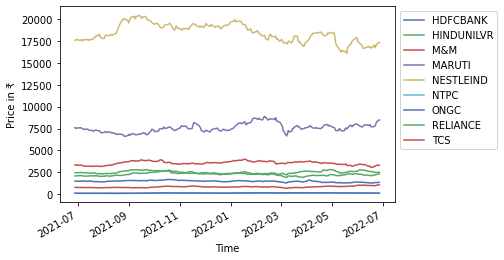

In [42]:
portfolio.plot(x ='Time', y = portfolio.columns[1:], kind = 'line')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Price in \u20B9')
plt.show()

In [76]:
def randomly_weighted_portfolios_with_selected_stocks(nof_portfolio, portfolio_return, portfolio_sigma):
    random_portfolios = np.zeros((2,nof_portfolio))
    for i in range(nof_portfolio):
        weight = np.random.random(105)
        #print(weight)
        #print(np.sum(weight))
        weight /= 100
        random_portfolios[0,i] = find_expected_daily_return_sp(weight, portfolio_return,len(result_list))*252*100
        random_portfolios[1,i] = find_risk_sp(weight, portfolio_sigma,len(result_list))*(252**0.5)
    return random_portfolios

In [77]:
# Python3 code to demonstrate working of 
# All Possible unique K size combinations till N
# Using combinations_with_replacement()
from itertools import combinations, permutations, product, combinations_with_replacement
import numpy as np
import pandas as pd
import functools
import operator


def extend(a):
    out = []
    for sublist in a:
        out.extend(sublist)
    return out

def find_bs():
    # initializing N
    N = 2
    
    # Initialize K
    K = 10
    
    # All Possible unique K size combinations till N
    # Using combinations_with_replacement()
    res = list(combinations_with_replacement(range(N), K))

    b = []
    for i in range(len(res)):
        if i!= 0:
            a = list(set(permutations(res[i] , 10)))
            for l in a:
                b.append(l)
    return b


In [86]:
def all_bs_portfolios_with_selected_stocks(nof_portfolio,portfolio_return, portfolio_sigma):
    all_b_list = find_bs()
   
    random_portfolios = np.zeros((3,len(all_b_list)))
    total_portfolios  = []
    for j in range(nof_portfolio):
        weight = np.random.random(len(stocks))
        weight /= np.sum(weight)
        for i in range(len(all_b_list)):
            random_portfolios[0,i] = find_expected_daily_return_b(weight, all_b_list[i], portfolio_return)*252*100
            random_portfolios[1,i] = find_risk_b(weight,all_b_list[i], portfolio_sigma)*(252**0.5)*100
            random_portfolios[2,i] = sum(all_b_list[i])
        total_portfolios.append(random_portfolios)
        random_portfolios = np.zeros((3,len(all_b_list)))
    total_portfolios = np.asanyarray(total_portfolios)
    return total_portfolios

In [94]:
#Reference: https://colab.research.google.com/drive/1ulDSw7DEJH1SYRVwvtJXYU0naFgaaBiR#scrollTo=PdrqsFBD3tIb
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
import itertools
#if using a Jupyter notebook, include:
%matplotlib inline




def visualize_efficient_frontier_for_selected_stocks():
    simulated_portfolios = randomly_weighted_portfolios_with_selected_stocks(25000,mu,sigma)
    plt.figure(figsize=(10, 7))
    plt.scatter(simulated_portfolios[1,:],simulated_portfolios[0,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(x = np.array([14.724668281815921]), y = np.array([13.85906067880955]), color = 'hotpink')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.ylabel('Expected Annaul retrun on investment')
    plt.xlabel('Annaul Risk Percentage')
    plt.show()

def visualize_efficient_frontier_for_bs():

    simulated_portfolios = all_bs_portfolios_with_selected_stocks(10,mu,sigma)

    tempz = []
    tempx = []
    tempy = []

    for i in simulated_portfolios:
        tempz.append(list(np.ravel(i[1,:])))
        tempx.append(list(np.ravel(i[2,:])))
        tempy.append(list(np.ravel(i[0,:])))
    
    tempz = list(itertools.chain(*tempz))
    tempx = list(itertools.chain(*tempx))
    tempy = list(itertools.chain(*tempy))  

    z = tempz
    x, y = tempx , tempy
    fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z,
                   alphahull=5,
                   opacity=1,
                   color='cyan')])
    fig.add_trace(
    go.Scatter3d(x= [4,8],
                 y= [21.2, 14.724668281815921],
                 z= [30.6, 13.85906067880955],
                 mode='markers')
                )
    fig.show()


   # x, y = list(np.ravel(simulated_portfolios[2,:])) , list(np.ravel(simulated_portfolios[0,:]))
    #X,Y = np.meshgrid(x,y)
    #Z = list(np.ravel(simulated_portfolios[1,:]))


    #fig = plt.figure(figsize=(6,6))
    #ax = fig.add_subplot(111, projection='3d')


    # Plot a 3D surface
    #ax.plot_surface(X, Y, Z)


    #plt.show()

    



In [95]:
visualize_efficient_frontier_for_bs()
#visualize_efficient_frontier_for_selected_stocks()

In [ ]:
terms=[]
t1 = Return(mu,n)
t2 = risk(sigma,n,1)
t3 = budget_constraint(2*n,n,8)
terms= t1+ t2 + t3
problem = Problem(name="Portfolio optimization", problem_type=ProblemType.pubo, terms=terms)

Number of terms in return:  49
Number of terms in risk:  2401


In [ ]:
# Instantiate a solver to solve the problem. 
solver = ParallelTempering(workspace)

# Optimize the problem
solution = solver.optimize(problem)

.......

In [ ]:
print(solution['configuration'])
result = solution['configuration']

selected_stocks=[]
prices_selected=[]
index_prices_selected= []

daily_prices = data.drop(['Time'], axis=1).to_numpy()


for i in result.keys():
    if result[i]:
        selected_stocks.append(stocks[int(i)])
        prices_selected.append(cp[int(i)])
        index_prices_selected.append(int(i))
        
print("\nSelected stocks are -\n", selected_stocks)

print("\nPrice of selected stocks are -\n", prices_selected)

{'0': 0, '1': 1, '2': 0, '3': 1, '4': 1, '5': 0, '6': 1, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 1, '27': 0, '28': 0, '29': 0, '30': 0, '31': 1, '32': 0, '33': 0, '34': 1, '35': 0, '36': 0, '37': 0, '38': 0, '39': 0, '40': 0, '41': 1, '42': 0, '43': 0, '44': 0, '45': 0, '46': 0, '47': 0, '48': 0}

Selected stocks are -
 ['ADANIGREEN', 'ADANIPOWER', 'ADANITRANS', 'ATGL', 'ITC', 'MARUTI', 'ONGC', 'SUNPHARMA']

Price of selected stocks are -
 [1906.6661531149095, 273.4378450035677, 2149.2141705744434, 2295.5344228094573, 268.7899822046573, 8485.913280085733, 140.30607119371885, 842.2730643765593]


In [ ]:
# Printing results

print("\n DIVERSIFIED PORTFOLIO:")
no_of_shares = distributed_budget(1000000, selected_stocks, cp)
edroi = find_expected_daily_return()
print("\nConstraints:")
print("\nBudget : ",  u"\u20B9", 1000000)
print("\nStock Appetite: ", 8 , " stocks")
print("\nRisk Aversion index of :" , 1,"\n")
print("\nExpected Daily Return on Investment : ", round(edroi*100,3), "%" )
print("\nExpected Monthly Return on Investment : ", round((edroi* 22 *100),3), "%")
print("\nExpected Annual Return on Investment : ", round((edroi*252 *100),3), "%")
print("\nExpected Annual Return: ",  u"\u20B9", round((1000000 + edroi*252*1000000),1))
print("\nAnnual Risk percentage: ", round(find_risk()*(252**0.5),4) ,"%")
print(edroi*22*100)
print(find_risk())

print("\n\nClasscial Comparision: ")

return_based_on_classical_w = find_expected_daily_return_sp(w_classical, muc, 8)

risk_based_on_classical_w  = find_risk_sp(w_classical_all, (sample_cov.reset_index(drop = True)).to_numpy(), 49)

print("\nClasscial Expected Daily Return on Investment : ", round(return_based_on_classical_w,3), "%" )
print("\nExpected Monthly Return on Investment : ", round((return_based_on_classical_w * 22),3), "%")
print("\nExpected Annual Return on Investment : ", round((return_based_on_classical_w*252),3), "%")
print("\nExpected Annual Return: ",  u"\u20B9", round((1000000 + ((return_based_on_classical_w*252*1000000)/100)),1))
print("\nAnnual Risk percentage: ", round(risk_based_on_classical_w,4) ,"%")












 DIVERSIFIED PORTFOLIO:
ADANIGREEN  :  65  shares
ADANIPOWER  :  457  shares
ADANITRANS  :  58  shares
ATGL  :  54  shares
ITC  :  465  shares
MARUTI  :  14  shares
ONGC  :  890  shares
SUNPHARMA  :  148  shares

Constraints:

Budget :  ₹ 1000000

Stock Appetite:  8  stocks

Risk Aversion index of : 1 


Expected Daily Return on Investment :  0.206 %

Expected Monthly Return on Investment :  4.537 %

Expected Annual Return on Investment :  51.967 %

Expected Annual Return:  ₹ 1519666.8

Annual Risk percentage:  23.4941 %
4.536773705582087
1.479987868540278


Classcial Comparision: 

Classcial Expected Daily Return on Investment :  0.641 %

Expected Monthly Return on Investment :  14.098 %

Expected Annual Return on Investment :  161.49 %

Expected Annual Return:  ₹ 2614898.9

Annual Risk percentage:  28.9528 %
